In [2]:
import pandas as pd
import numpy as np
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc
import matplotlib.pyplot as plt
import pingouin as pg
from pingouin import ancova
import seaborn as sns

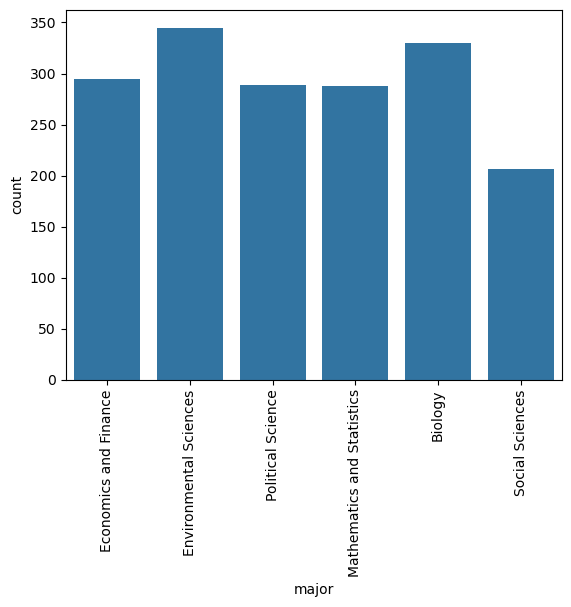

In [3]:
#%% Cargar la base de datos
data = pd.read_csv(r'C:\Users\Daniela de la Torre\OneDrive\Escritorio\4to_Semestre\Analisis Estadistico Multivariado\students (1).csv')

# Filtrar los estudiantes graduados
graduated_student = data[data['graduated'] == 1]

sns.countplot(data=graduated_student, x='major')
plt.xticks(rotation=90)
plt.show()


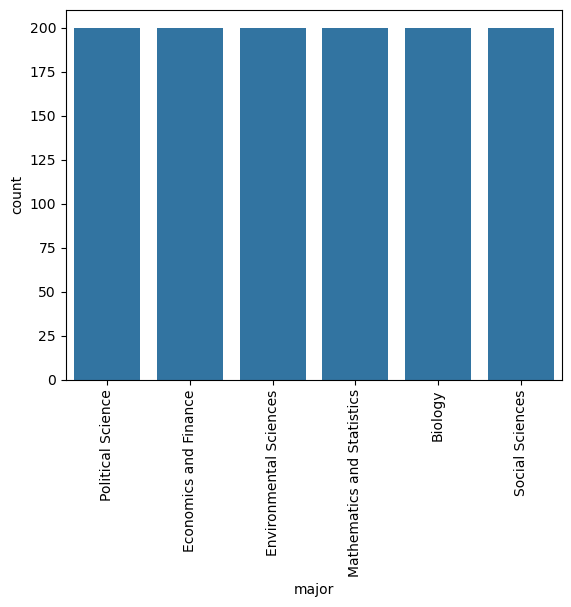

In [ ]:
#%% Seleccionar algunas especialidades y extraer una muestra
specialties = ['Political Science', 'Economics and Finance', 'Environmental Sciences', 
               'Mathematics and Statistics', 'Biology', 'Social Sciences']
sample_size = 200

sample_list = []  
for specialty in specialties:
    sample = graduated_student[graduated_student['major'] == specialty].sample(sample_size, random_state = 42)
    sample_list.append(sample)

# Concatenar todas las muestras en un único DataFrame
sample = pd.concat(sample_list)
sample.rename(columns={"nc.score": "GPA"}, inplace=True)

sns.countplot(data=sample, x='major')
plt.xticks(rotation=90)
plt.show()




Resumen Estadístico de Salary por Major:
                              N        Mean         SD        SE   95% Conf.  \
major                                                                          
Biology                     200  47420.9587  8939.3448  632.1071  46174.4709   
Economics and Finance       200  49540.3771  8453.5551  597.7566  48361.6270   
Environmental Sciences      200  37541.1325  5913.4536  418.1443  36716.5701   
Mathematics and Statistics  200  48299.3765  8432.4084  596.2613  47123.5751   
Political Science           200  36228.6783  9521.0587  673.2405  34901.0773   
Social Sciences             200  32052.6434  6201.5980  438.5192  31187.9026   

                              Interval  
major                                   
Biology                     48667.4465  
Economics and Finance       50719.1271  
Environmental Sciences      38365.6949  
Mathematics and Statistics  49475.1779  
Political Science           37556.2794  
Social Sciences             3

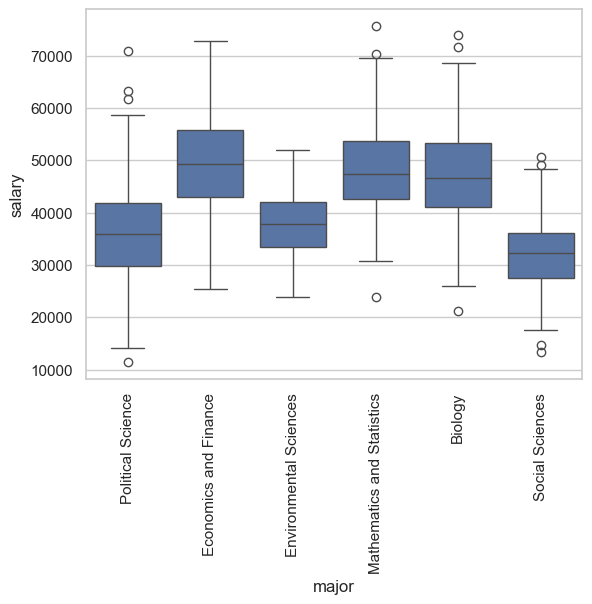

In [ ]:
#%% Resumen Estadístico
resumen = rp.summary_cont(sample['salary'].groupby(sample['major']))
print("Resumen Estadístico de Salary por Major:")
print(resumen)

# BoxPlot
sns.set(style="whitegrid")
sns.boxplot(x='major', y='salary', data=sample)
plt.xticks(rotation=90)
plt.show()


In [ ]:
#%% Supuestos para ANCOVA

# Nota: Para ANCOVA, además de los supuestos del ANOVA, debemos verificar la relación lineal 
# entre la covariable (GPA) y la variable dependiente (salary) y que la covariable sea independiente del factor.

# Normalidad de los residuos del modelo ANCOVA se evaluará más adelante en el modelo ajustado.


In [ ]:
#%% Homocedasticidad: Se pueden usar las pruebas de Levene y Bartlett como en ANOVA
print("Prueba de Homocedasticidad (Levene):")
levene_test = pg.homoscedasticity(sample, dv='salary', group='major', method='levene')
print(levene_test)

print("Prueba de Homocedasticidad (Bartlett):")
bartlett_test = pg.homoscedasticity(sample, dv='salary', group='major', method='bartlett')
print(bartlett_test)


Prueba de Homocedasticidad (Levene):
               W          pval  equal_var
levene  10.81775  3.418504e-10      False
Prueba de Homocedasticidad (Bartlett):
                  T          pval  equal_var
bartlett  73.050469  2.372771e-14      False


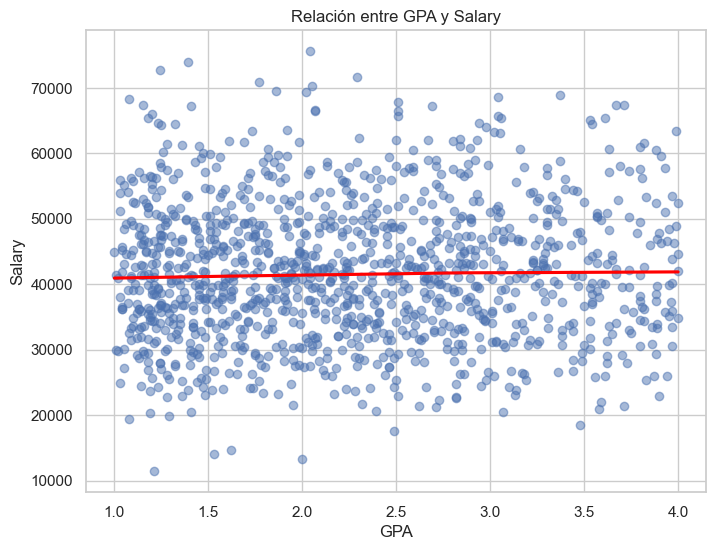

In [ ]:
#%% Verificar la relación lineal entre la covariable (GPA) y salary
plt.figure(figsize=(8, 6))
sns.regplot(x='GPA', y='salary', data=sample, lowess=True, line_kws={'color': 'red'}, scatter_kws={'alpha':0.5})
plt.title("Relación entre GPA y Salary")
plt.xlabel("GPA")
plt.ylabel("Salary")
plt.grid(True)
plt.show()

In [ ]:
#%% ANCOVA: Modelo con interacción entre GPA y major
# Para evaluar si la pendiente entre GPA y salary difiere entre especialidades
model_ancova_int = ols('salary ~ GPA * major', data=sample).fit()
anova_table_ancova_int = sm.stats.anova_lm(model_ancova_int, typ=2)
print("Tabla ANCOVA (con interacción GPA * major):")
print(anova_table_ancova_int)
# Si la interacción no es significativa, se opta por el modelo sin interacción

Tabla ANCOVA (con interacción GPA * major):
                 sum_sq      df           F         PR(>F)
major      5.563501e+10     5.0  172.488417  4.778483e-138
GPA        1.468036e+08     1.0    2.275718   1.316801e-01
GPA:major  1.421764e+08     5.0    0.440798   8.201533e-01
Residual   7.663632e+10  1188.0         NaN            NaN


In [ ]:
#%%
print(model_ancova_int.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     78.74
Date:                Wed, 02 Apr 2025   Prob (F-statistic):          6.71e-133
Time:                        22:36:30   Log-Likelihood:                -12486.
No. Observations:                1200   AIC:                         2.500e+04
Df Residuals:                    1188   BIC:                         2.506e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

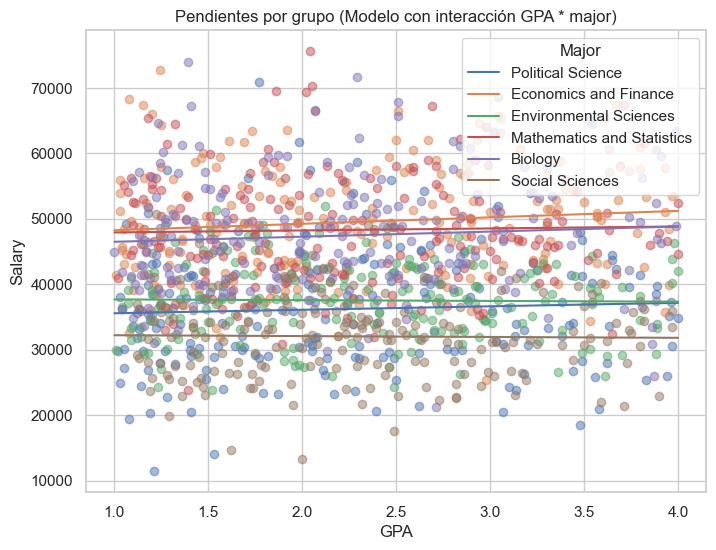

In [ ]:
#%% Gráfica de las pendientes

# Definir un rango de valores para GPA
gpa_range = np.linspace(sample['GPA'].min(), sample['GPA'].max(), 100)

plt.figure(figsize=(8,6))

# Iterar sobre cada nivel de 'major'
for group in sample['major'].unique():
    # Crear un DataFrame para predicciones: se fija 'major' y se varía GPA
    new_data = pd.DataFrame({'GPA': gpa_range, 'major': group})
    
    # Predecir salary usando el modelo con interacción
    pred = model_ancova_int.predict(new_data)
    
    # Graficar la línea de predicción para este grupo
    plt.plot(gpa_range, pred, label=group)
    
    # Graficar los datos reales para el grupo
    group_data = sample[sample['major'] == group]
    plt.scatter(group_data['GPA'], group_data['salary'], alpha=0.5)

plt.xlabel('GPA')
plt.ylabel('Salary')
plt.title('Pendientes por grupo (Modelo con interacción GPA * major)')
plt.legend(title='Major')
plt.show()

In [ ]:
#%% ANCOVA: Modelo básico sin interacción
# Se ajusta el modelo: salary ~ GPA (covariable) + major (factor)
model_ancova = ols('salary ~ GPA + major', data=sample).fit()
anova_table_ancova = sm.stats.anova_lm(model_ancova, typ=2)
print("Tabla ANCOVA (sin interacción):")
print(anova_table_ancova)

# Evaluar los residuos del modelo ANCOVA para normalidad
residuals = model_ancova.resid
normality_test = pg.normality(residuals)
print("Prueba de Normalidad de los residuos del modelo ANCOVA:")
print(normality_test)

Tabla ANCOVA (sin interacción):
                sum_sq      df           F         PR(>F)
major     5.563501e+10     5.0  172.893625  1.952503e-138
GPA       1.468036e+08     1.0    2.281065   1.312268e-01
Residual  7.677850e+10  1193.0         NaN            NaN
Prueba de Normalidad de los residuos del modelo ANCOVA:
          W      pval  normal
0  0.992043  0.000005   False


In [ ]:
#%%
print(model_ancova.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     144.3
Date:                Wed, 02 Apr 2025   Prob (F-statistic):          1.33e-137
Time:                        22:37:03   Log-Likelihood:                -12487.
No. Observations:                1200   AIC:                         2.499e+04
Df Residuals:                    1193   BIC:                         2.502e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [ ]:
#%% Comparación múltiple (post hoc) para el factor 'major' en el modelo ANCOVA sin interacción
# Se obtienen las medias ajustadas (estimadas) para cada grupo
means_adjusted = model_ancova.predict(sample)
sample['adjusted_salary'] = sample['salary'] - (sample['GPA'] - sample['GPA'].mean()) * model_ancova.params['GPA']

comp = mc.MultiComparison(sample['adjusted_salary'], sample['major'])
post_hoc_res = comp.tukeyhsd()
print("Comparaciones múltiples (Tukey) para las medias ajustadas por GPA:")
print(post_hoc_res.summary())

Comparaciones múltiples (Tukey) para las medias ajustadas por GPA:
                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                          
          group1                     group2             meandiff  p-adj     lower       upper    reject
-------------------------------------------------------------------------------------------------------
                   Biology      Economics and Finance   2072.1038 0.1019   -216.7841   4360.9918  False
                   Biology     Environmental Sciences  -9927.3331    0.0  -12216.221  -7638.4451   True
                   Biology Mathematics and Statistics    859.5689 0.8925  -1429.3191   3148.4569  False
                   Biology          Political Science -11206.8979    0.0 -13495.7859  -8918.0099   True
                   Biology            Social Sciences -15402.5938    0.0 -17691.4817 -13113.7058   True
     Economics and Finance     Environmental Sciences -11999.4369    0.0 -14288.3249   -9710.549   Tr

In [ ]:
#%% ANCOVA con pingouin
ancova(data=sample, dv='salary', covar='GPA', between='major')


,Source,SS,DF,F,p-unc,np2
0,major,5.563501e+10,5,172.893625,1.952503e-138,0.420161
1,GPA,1.468036e+08,1,2.281065,1.312268e-01,0.001908
2,Residual,7.677850e+10,1193,NaN,NaN,NaN


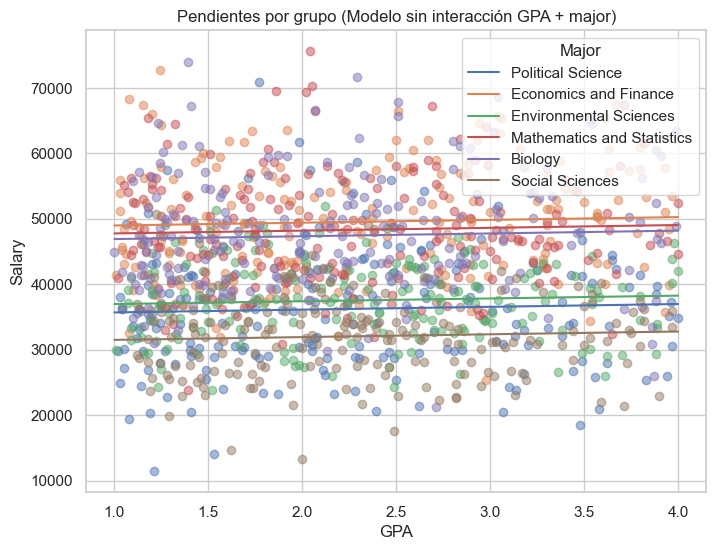

In [ ]:
#%% Definir un rango de valores para GPA
gpa_range = np.linspace(sample['GPA'].min(), sample['GPA'].max(), 100)

plt.figure(figsize=(8,6))

# Iterar sobre cada nivel de 'major'
for group in sample['major'].unique():
    # Crear un DataFrame para predicciones: se fija 'major' y se varía GPA
    new_data = pd.DataFrame({'GPA': gpa_range, 'major': group})
    
    # Predecir salary usando el modelo con interacción
    pred = model_ancova.predict(new_data)
    
    # Graficar la línea de predicción para este grupo
    plt.plot(gpa_range, pred, label=group)
    
    # Graficar los datos reales para el grupo
    group_data = sample[sample['major'] == group]
    plt.scatter(group_data['GPA'], group_data['salary'], alpha=0.5)

plt.xlabel('GPA')
plt.ylabel('Salary')
plt.title('Pendientes por grupo (Modelo sin interacción GPA + major)')
plt.legend(title='Major')
plt.show()
